### Emma Klemets, 260775167   
All my work, code, output and written answers for **Q1** are in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1) 
The end result is that dish zenith.txt contains the (x,y,z) positions in mm of a few hundred targets placed on the dish. The ideal telescope dish should be a rotationally symmetric paraboloid. We will try to measure the shape of that paraboloid, and see how well we did.

#### a) 
Helpfully, I have oriented the points in the file so that the dish is pointing in the +z direction (in the general problem, you would have to fit for direction the dish is pointing in as well, but we will skip that here). For a rotationally symmetric paraboloid, we know that   
$z-z_0 = a ((x - x_0)^2 + (y - y_0)^2)$   
and we need to solve for x0, y0, z0, and a. While at first glance this problem may appear non-linear, show that we can pick a new set of parameters that make the problem linear. What are these new parameters, and how do they relate to the old ones?


We can linearize the equation like this:


$
z = a(x^2+y^2) - (2ax_0)x - (2ay_0)y + (a(x_0^2 + y_0^2) + z_0)   \\
= A(x^2+y^2) + Bx + Cy + D
$

such that   
$
A = a \\
B = - 2 a x_0\\
C = - 2 a y_0\\
D = a(x_0^2 + y_0^2) + z_0
$

In [2]:
def better_parab(x, y, A, B, C, D):
    return A*(x**2 + y**2) + B*x + C*x + D

x_0 = lambda a, B: -B/(2*a)
y_0 = lambda a, C: -C/(2*a)

z_0 = lambda a, x_0, y_0, D: D - a*(y_0**2 + x_0**2)

#### b) 
Carry out the fit. What are your best-fit parameters?

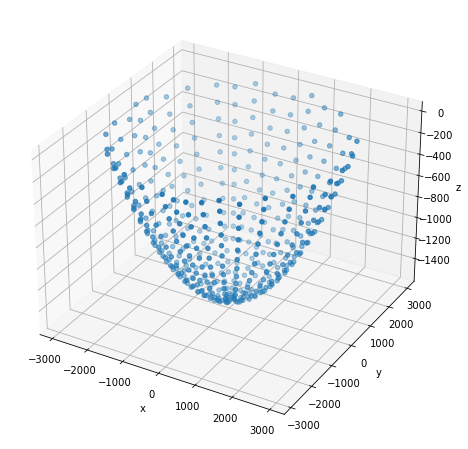

In [39]:
#load data
data = np.transpose(np.loadtxt("dish_zenith.txt")) #mm

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.scatter(data[0], data[1], data[2])
plt.show()

In [4]:
def betterls_Fit(x, y, z):
    nParam = 4

    #A_i = [x[i]^2 +y[i]^2, 1] (one row)
    A=np.zeros([len(x), nParam])
    
    A[:,3]=1.0
    
    for i in range(0, len(data[0])):
        A[i,0] = x[i]**2 + y[i]**2
        A[i,1] = x[i]
        A[i,2] = y[i]

    # print(A)

    A=np.matrix(A)
    d=np.matrix(z).transpose()

    lhs=A.transpose()*A
    rhs=A.transpose()*d

    #gives m [[a], [m]]
    fittedParams= np.linalg.inv(lhs)*rhs
    
    #get covarience matrix for error calculations
    cov = np.linalg.inv(lhs)

    predVals = A*fittedParams
    # print(predVals)

    val = []
    for i in predVals:
    #     print(i[0,0])
        val.append(i[0,0])
        
    return fittedParams.reshape(nParam), val, cov

best fit parameters: [[ 1.66704455e-04  4.53599028e-04 -1.94115589e-02 -1.51231182e+03]]


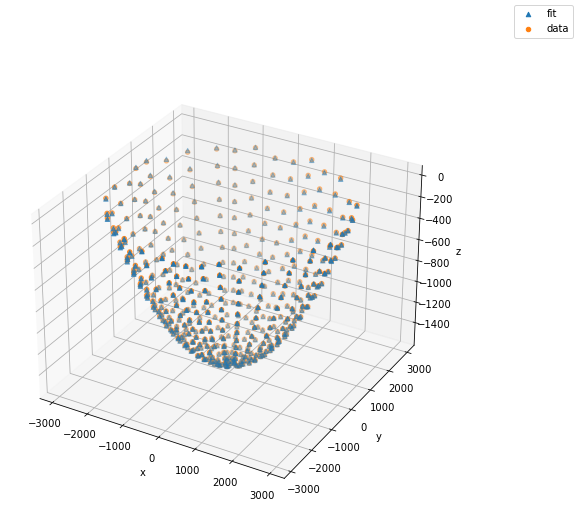

In [41]:
fittedParams, val, cov = betterls_Fit(data[0], data[1], data[2])

print("best fit parameters: {}".format(fittedParams))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[0], data[1], val, label="fit", marker="^") #(x, z)

ax.scatter(data[0], data[1], data[2], label='data') #(x, z)
fig.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

fittedParams = np.array(fittedParams)

a = fittedParams[0][0]
B = fittedParams[0][1]
C = fittedParams[0][2]
D = fittedParams[0][3]

x0 = x_0(a, B)
y0 = y_0(a, C)
z0 = z_0(a, x0, y0, D)

fits = [a, x0, y0, z0]

#### c) 
Estimate the noise in the data, and from that, estimate the uncertainty in a. Our target focal length was 1.5 metres. What did we actually get, and what is the error bar? In case all facets of conic sections are not at your immediate recall, a parabola that goes through (0, 0) can be written as y = x^2 / (4f) where f is the focal length. When calculating the error bar for the focal length, feel free to approximate using a first-order Taylor expansion.

In [43]:
#get noise from std of the residuals
rms = np.std(data[2] - val)

print("Estimated noise in data:", rms, "mm")

#rescale covariance matrix by noise
noisyCov = cov/rms

#get error on a
err = np.sqrt(np.diag(noisyCov))

name = ["a", "x0", "y0", "z0"]

print("{}: {:.4e} +/- {:.1e} 1/mm".format(name[0], fits[0], err[0]))

for i in range(1,4):
    print("{}: {:.4e} +/- {:.1e} mm".format(name[i], fits[i], err[i]))

#get focal length and convert to meters
F = 1/(4*(a)) * 0.001

#error propogation
#errF = 0.001/4 * errA * F^2
errF = 1/4 * (err[0]/0.001 * F**2)           

print("\nOur fit gets a focal length of {:.6} +/- {:.2e} m".format(F, errF))

Estimated noise in data: 3.7683386487847277 mm
a: 1.6670e-04 +/- 8.8e-09 1/mm
x0: -1.3605e+00 +/- 1.7e-05 mm
y0: 5.8221e+01 +/- 1.6e-05 mm
z0: -1.5129e+03 +/- 4.3e-02 mm

Our fit gets a focal length of 1.49966 +/- 4.96e-06 m
